In [ ]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
from torch import optim
import torch
import matplotlib.pyplot as plt


import torch
from torch import nn

In [ ]:
device = 'cuda'
# device = 'cpu'

In [ ]:
batch_size = 64
LATENT_DIM = 64
HID_DIM = 64
LR = 2e-4
CRITIC_STEPS = 5
N_EPOCHS = 30
GRAD_WEIGHT = 10


In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255



y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
X_train = torch.Tensor(X_train).unsqueeze(1)
X_test = torch.Tensor(X_test).unsqueeze(1)
X_train.shape, X_test.shape

train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hid_dims=HID_DIM, n_emb=10, emb_dim=5):
        super().__init__()
        self.latent_dim = latent_dim
        self.hid_dims = hid_dims
        self.n_emb = n_emb
        self.emb_dim = n_emb


        self.out = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim + self.emb_dim, self.hid_dims, 3, 2),
            nn.BatchNorm2d(self.hid_dims),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims, self.hid_dims * 2, 4, 1),
            nn.BatchNorm2d(self.hid_dims * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims * 2, self.hid_dims, 3, 2),
            nn.BatchNorm2d(self.hid_dims),
            nn.ReLU(),
            nn.ConvTranspose2d(self.hid_dims, 1, 4, 2),
            nn.Tanh(),
        )
        self.input_tower = nn.Sequential(nn.Linear(self.latent_dim, self.latent_dim),
                                         nn.ReLU()
                                         )
        self.label_tower = nn.Sequential(nn.Embedding(self.n_emb, self.emb_dim),
                                         nn.ReLU(),
                                         nn.Linear(self.emb_dim, self.emb_dim),
                                         nn.ReLU()
                                         )

    def forward(self, z, labels):
        z = self.input_tower(z)
        labels_emb = self.label_tower(labels)
        z = torch.concat([z, labels_emb], dim=1)
        z = z.view(len(z), self.latent_dim + self.emb_dim, 1, 1)
        z = self.out(z)
        return z

gen = Generator()
gen(torch.randn(64, LATENT_DIM), torch.randint(0, 9, (64, ))).shape, sum([p.numel() for p in gen.parameters() if p.requires_grad])


(torch.Size([64, 1, 28, 28]), 253587)

In [ ]:
class Critic(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, hid_dims=HID_DIM, n_emb=10, emb_dim=5):
        super().__init__()
        self.latent_dim = latent_dim
        self.hid_dims = hid_dims
        self.n_emb = n_emb
        self.emb_dim = n_emb
        self.input_tower = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hid_dims, kernel_size=4, stride=2),
            nn.BatchNorm2d(hid_dims),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hid_dims, out_channels=hid_dims * 2, kernel_size=4, stride=2),
            nn.BatchNorm2d(2 * hid_dims),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=2 * hid_dims, out_channels=hid_dims, kernel_size=4, stride=2),
        )
        self.label_tower = nn.Sequential(nn.Embedding(self.n_emb, self.emb_dim),
                                         nn.ReLU(),
                                         nn.Linear(self.emb_dim, self.emb_dim),
                                         nn.ReLU()
                                         )
        self.out = nn.Sequential(nn.Linear(self.hid_dims + self.emb_dim, self.hid_dims),
                                 nn.BatchNorm1d(hid_dims),
                                 nn.ReLU(),
                                 nn.Linear(self.hid_dims, 1)
                                 )


    def forward(self, x, labels):
        x = self.input_tower(x).flatten(1)
        labels_emb = self.label_tower(labels)
        x = torch.concat([x, labels_emb], dim=1)
        x = self.out(x)
        return x

In [ ]:
# Normalize the weights of generator and critic
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [ ]:
crit = Critic()
crit(torch.randn(64, 1, 28, 28), torch.randint(0, 9, (64, ))).shape

torch.Size([64, 1])

In [ ]:

crit = Critic().to(device).apply(weights_init)
gen = Generator().to(device).apply(weights_init)

opt_gen = optim.Adam(params=gen.parameters(), betas=(0.5, 0.999))
opt_crit = optim.Adam(params=crit.parameters(), betas=(0.5, 0.999))


critic_loss_hist, gen_loss_hist = [], []


for _ in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        for _ in range(CRITIC_STEPS):
            mean_critic_loss = 0
            batch_size = len(data)
            opt_crit.zero_grad()
            fake_samples = gen(torch.randn(batch_size, LATENT_DIM, device=device), labels)
            crit_fake_preds = crit(fake_samples, labels)
            crit_real_preds = crit(data, labels)

            # Grad to mixed images
            epsilon = torch.rand(batch_size, 1, 1, 1, requires_grad=True, device=device)
            mixed_images = data * epsilon + fake_samples * (1 - epsilon)
            mixed_scores = crit(mixed_images, labels)
            grads = torch.autograd.grad(
                inputs=mixed_images,
                outputs=mixed_scores,
                grad_outputs=torch.ones_like(mixed_scores),
                create_graph=True,
                retain_graph=True
            )[0]
            grad_norm = grads.flatten(1).norm(2, dim=1)
            grad_penanlty = torch.mean((grad_norm - 1) ** 2)
            critic_loss = crit_fake_preds.mean() - crit_real_preds.mean() + GRAD_WEIGHT * grad_penanlty
            critic_loss.backward()
            opt_crit.step()
            mean_critic_loss += critic_loss.detach().cpu().item()
        critic_loss_hist.append(mean_critic_loss)

        opt_gen.zero_grad()
        fake_samples = gen(torch.randn(batch_size, LATENT_DIM, device=device), labels)
        crit_fake_preds = crit(fake_samples, labels)
        generator_loss = - crit_fake_preds.mean()
        generator_loss.backward()
        generator_loss = generator_loss.detach().cpu().item()
        gen_loss_hist.append(generator_loss)
        opt_gen.step()


    pbar.set_description(f'{generator_loss=},{mean_critic_loss=}')


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
generator_loss=4839.62109375,mean_critic_loss=18.240066528320312: 100%|██████████| 30/30 [37:28<00:00, 74.96s/it]


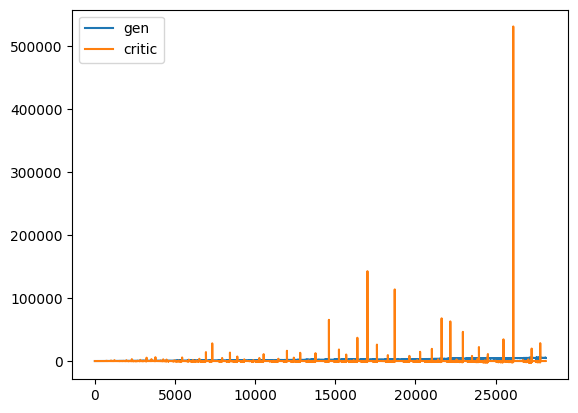

In [ ]:
plt.plot(gen_loss_hist, label='gen')
plt.plot(critic_loss_hist, label='critic')
plt.legend();


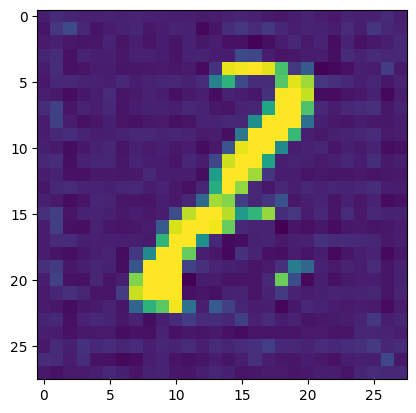

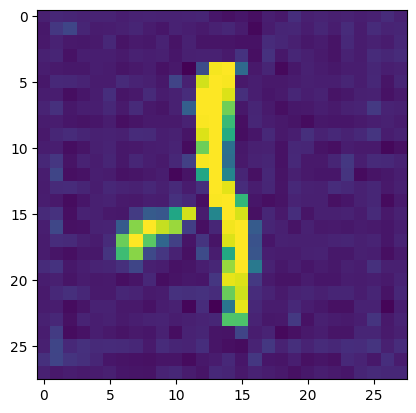

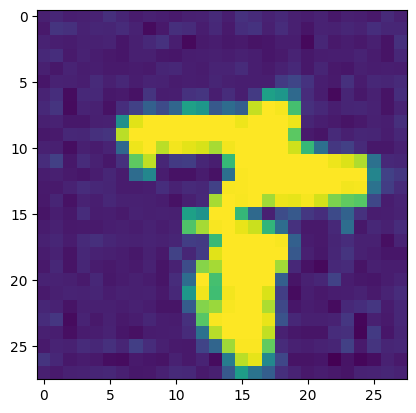

In [ ]:
n_samples = 3

with torch.no_grad():
  fake_samples = gen(torch.randn(n_samples, LATENT_DIM, device=device), 1 * torch.ones(n_samples, device=device).long())

for i in range(n_samples):
    plt.imshow(fake_samples[i].squeeze().cpu().numpy())
    plt.show()

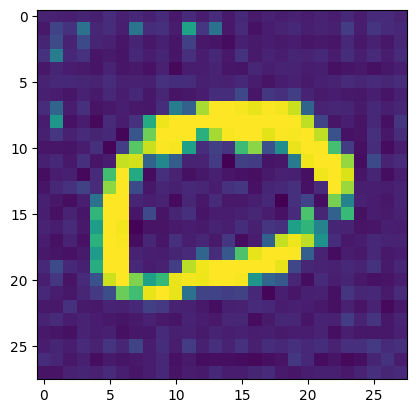

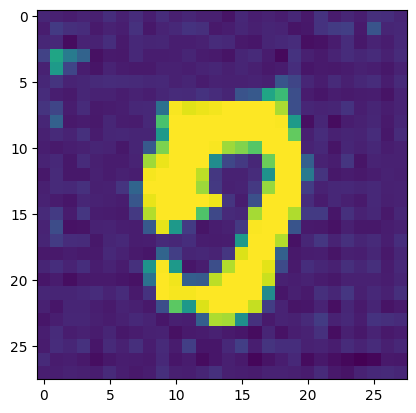

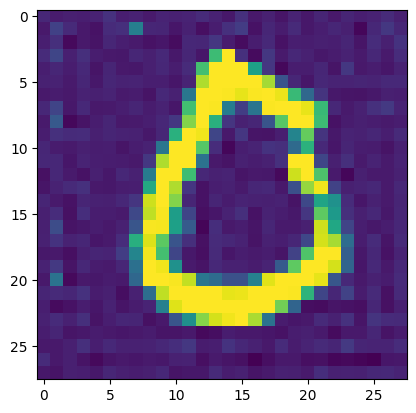

In [ ]:
n_samples = 3

with torch.no_grad():
  fake_samples = gen(torch.randn(n_samples, LATENT_DIM, device=device), 0 * torch.ones(n_samples, device=device).long())

for i in range(n_samples):
    plt.imshow(fake_samples[i].squeeze().cpu().numpy())
    plt.show()

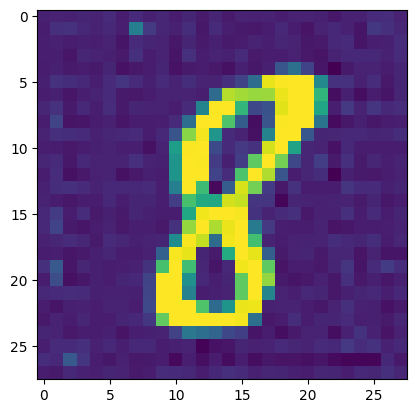

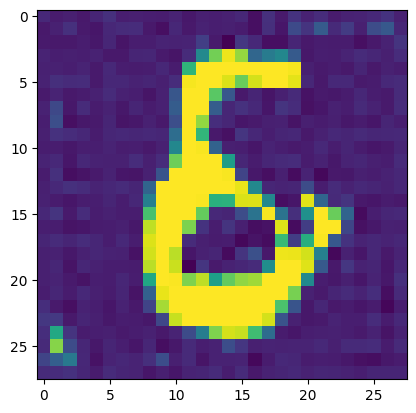

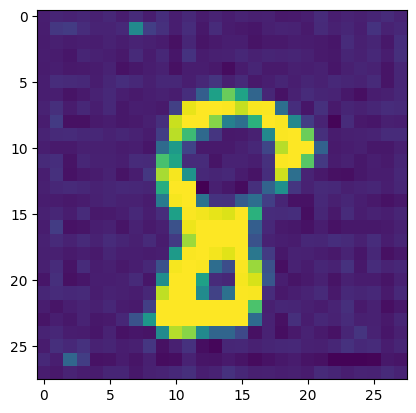

In [ ]:
n_samples = 3

with torch.no_grad():
  fake_samples = gen(torch.randn(n_samples, LATENT_DIM, device=device), 8 * torch.ones(n_samples, device=device).long())

for i in range(n_samples):
    plt.imshow(fake_samples[i].squeeze().cpu().numpy())
    plt.show()

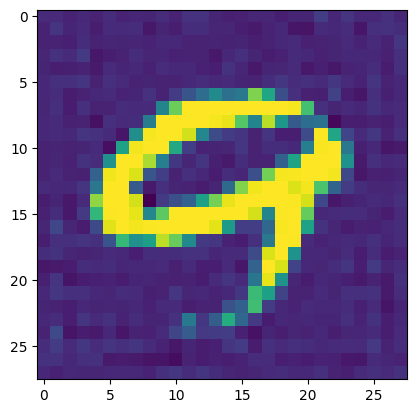

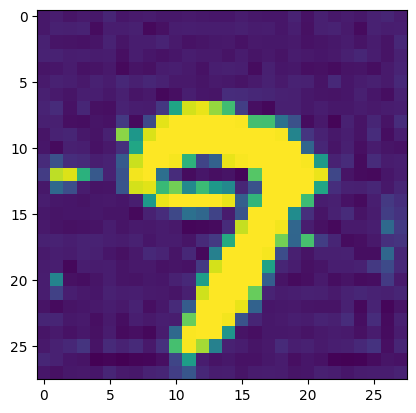

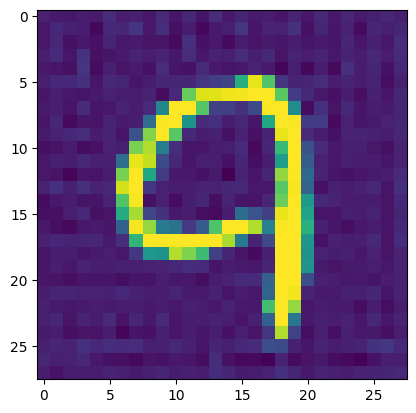

In [ ]:
n_samples = 3

with torch.no_grad():
  fake_samples = gen(torch.randn(n_samples, LATENT_DIM, device=device), 9 * torch.ones(n_samples, device=device).long())

for i in range(n_samples):
    plt.imshow(fake_samples[i].squeeze().cpu().numpy())
    plt.show()

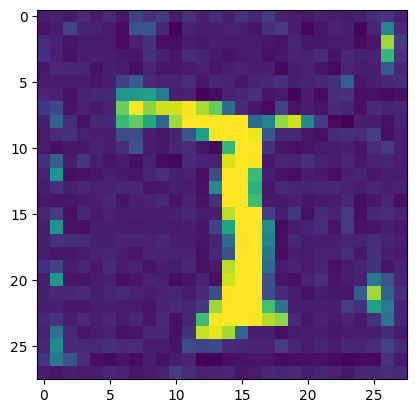

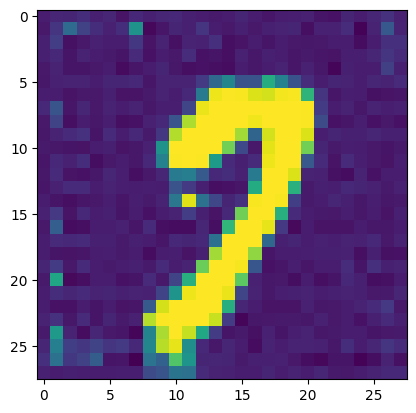

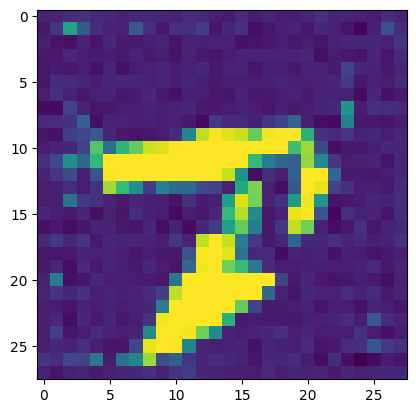

In [ ]:
n_samples = 3

with torch.no_grad():
  fake_samples = gen(torch.randn(n_samples, LATENT_DIM, device=device), 7 * torch.ones(n_samples, device=device).long())

for i in range(n_samples):
    plt.imshow(fake_samples[i].squeeze().cpu().numpy())
    plt.show()